In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# $$\textbf{Python Programming for Machine Learning} $$ 

#### $$\text{SoSe 2020/2021}$$

## $$\text{Lecture 4: Simulation of Markov chains, optimization,} $$
## $$\text{compilation with Numba and Cython}$$

#### $$\text{Sergej Dogadov} \quad \text{Philine Thalia Görzig} \quad \text{Panagiotis Tomer Karagiannis}$$

<center>
<img src='images/pyt.png' width=450>

## $$\textbf{Markov chains}$$
<hr>

* $\text{Markov chain transits between a set of states, where the transition between pairs of states}$

$\quad\quad\quad\text{is associated with a fixed probability.}$

* $\text{The set of probabilities can be stored in a transition matrix.}$

<center>
    <img src='./images/markov.png', width='1000'>

In [7]:
import numpy as np
# Transition matrix
T = np.array([
                [0.9, 0.1, 0.0], # transition from state 1 to state 1,2,3
                [0.0, 0.9, 0.1], # transition from state 2 to state 1,2,3
                [1.0, 0.0, 0.0], # transition from state 3 to state 1,2,3
            ])

## $$\textbf{ Transition matrix and initial states}$$
<hr> 

In [12]:
# Add empty state to transition matrix

pad_shape = ((0, 0), (1, 0))  # ((before_1, after_1), (before_2, after_2))

P = np.pad(T, pad_shape, mode='constant', constant_values=0) 
print(P)

#np.pad(T, pad_shape, mode='mean') # diff modes available like: mean, empty, func, etc

[[0.  0.9 0.1 0. ]
 [0.  0.  0.9 0.1]
 [0.  1.  0.  0. ]]


In [13]:
# Init tokens to start at the node 0
num_tokens = 4
starting_constellation = [1, 0, 0]

# explicit repetition
#X = np.tile(starting_constellation, reps=(num_tokens,1)) 

# implicit by broadcasting:

X = np.outer(num_tokens*[1], starting_constellation) # (4,) x (3,) -> (4,3)
X

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## $$\textbf{ Markov chain step }$$
<hr> 

In [14]:
def mc_step(X, P, verbose=False):
        
    Xp = np.dot(X, P) # one mc step 
    Xc = np.cumsum(Xp, axis=1)
    
    log = f'Xp:\n{Xp}\n\nXc:\n{Xc}\n\n'
    
    L, H = Xc[:, :-1], Xc[:, 1:] # lower and upper bounds
    
    log += f'L:\n{L}\n\nH:\n{H}\n'
    
    R = np.random.uniform(0, 1, (Xp.shape[0], 1)) # random state for each token
    
    log += f'\nR\n{R}\n'
    
    states = (R >= L) * (R < H) #equiv: np.logical_and((R > L), (R < H))
    
    log += f'\nNew states:\n{states.astype(np.int)}'
    
    if verbose:
        print(log)
        
    return states.astype('int32')

## $$\textbf{ Markov chain step }$$
<hr>

In [15]:
mc_step(X, P, 
        verbose=True);

Xp:
[[0.  0.9 0.1 0. ]
 [0.  0.9 0.1 0. ]
 [0.  0.9 0.1 0. ]
 [0.  0.9 0.1 0. ]]

Xc:
[[0.  0.9 1.  1. ]
 [0.  0.9 1.  1. ]
 [0.  0.9 1.  1. ]
 [0.  0.9 1.  1. ]]

L:
[[0.  0.9 1. ]
 [0.  0.9 1. ]
 [0.  0.9 1. ]
 [0.  0.9 1. ]]

H:
[[0.9 1.  1. ]
 [0.9 1.  1. ]
 [0.9 1.  1. ]
 [0.9 1.  1. ]]

R
[[0.24710871]
 [0.13232145]
 [0.40851308]
 [0.11382722]]

New states:
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


## $$\textbf{ Simulate Markov process}$$
<hr> 

In [16]:
from tqdm import tqdm

def simulate(X, P, num_steps=5000, verbose=False):

    for i in tqdm(range(num_steps)):
        
        X = mc_step(X, P, verbose)
        
        if verbose:
            print(str(X)+'\n')

    return X.mean(axis=0) # represents a prob of token to be in one of the Markov chain states

In [17]:
simulate(X, P)

100%|██████████| 5000/5000 [00:03<00:00, 1253.20it/s]


array([0.5, 0.5, 0. ])

# $$\textbf{ Optimization}$$
<hr>
<br>
<br>

<center>
    <img src='./images/optim.png' width='700'>

# $$\textbf{ Automatic differentiation with JAX}$$
<hr> 

<center>
    <img src='./images/JAX.png' width='400'>

In [20]:
#conda install -c conda-forge jax

import jax.numpy as np 
from jax import grad


## $$\textbf{ Taking univariate function derivatives}$$
<hr> 


$$y = 3 x^2 + 2, \quad y^{'}_{x} = 6x, \quad y^{''}_{x} = 6$$

In [117]:
# define a function to numerically comp a gradient for
import jax.numpy as np

def y(x):
    return 3 * np.square(x) + 2 # note that you are using jax numpy

# grad comp at the point
x0 = 10.   # has to be float no diff possible on integers

# first derivative
print(grad(y)(x0)) # evaluated at point x

# second
print(grad(grad(y))(100*x0))


60.0
6.0


## $$\textbf{ Multivariate function derivatives}$$
<hr> 
<br>
<center>
$y = 3 x_1^3 + 2^{x_2}, \quad \frac{\partial y}{\partial x_1} = 9 x_1^2  \quad  \frac{ \partial y}{\partial x_2} = 2^{x_2} \ln{2}$

In [118]:
x1 = 2. # has to be a float number
x2 = 3. # has to be a float number

y = lambda x1, x2 : 3 * np.power(x1, 3) + np.power(2, x2) # note you are using jax numpy


In [119]:
# wrt x_1 (first func arg)
val = grad(y, 0)(x1,x2) # 9 * 2**2 = 36

test_val = 9*x1**2
print(f'{val} == {test_val}')

assert np.isclose(val,test_val)

36.0 == 36.0


In [120]:
# wrt x_2
val = grad(y, 1)(x1, x2) # 2**(3)*ln(2)

test_val = 2**x2 * np.log(2)
print(f'{val} == {test_val}')

assert np.isclose(val, test_val, atol=1e-3) # 0.001 10**-3

5.545177459716797 == 5.545177459716797


* $\text{For more info about}\>$ <a href='https://jax.readthedocs.io/en/latest/notebooks/quickstart.html'>JAX</a>



## $$\textbf{ Gradient descent for finding minimum of a function}$$
<hr> 
<br>
$$y = kx^2 + const, \quad k=3$$

In [121]:
# a function to find a minimum numerically
import jax.numpy as np 

f = lambda x, coeff=3, offset=0: coeff * np.power(x, 2) + offset # jax numpy !

def minimize_(fn, x0, step_size, max_it): 

    vals = np.array([x0]).astype(np.float32) # list of the checked points

    for _ in range(max_it):
        
        grad_f = grad(fn)
        
        curr_val = vals[-1]
        if abs(grad_f(curr_val)) > 1e-2: # the derivative approx not zero
            
            next_val = curr_val - step_size*grad_f(curr_val)
            vals = np.append(vals, next_val)
            
        else:
            return vals
            
    return vals

In [122]:
vals = minimize_(f, x0=-5., step_size=0.01, max_it=10)
vals[:5]

DeviceArray([-5.       , -4.7      , -4.4179997, -4.15292  , -3.9037447],            dtype=float32)

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_minimize(x, f, max_it=10, step_size=0.01):
    
    plt.figure(figsize=(10, 8))    
    
    plt.plot(x, f(x), label='$f(x)$')
    
    vals = minimize_(f, x0=x[0], step_size=step_size, max_it=max_it)
    
    plt.plot(vals, f(vals), "o--", c="r", label='opt step')
    
    plt.legend(loc='best', fontsize=20)
    plt.grid()
    

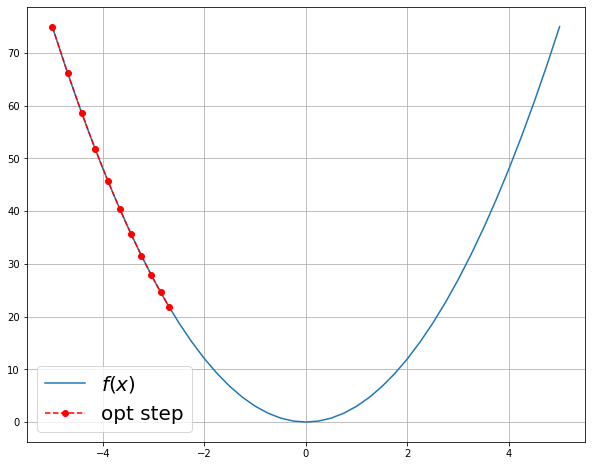

In [124]:
x = np.arange(-5, 5.01, 0.25) # function range
plot_minimize(x, f, max_it=10, step_size=1e-2)

## $$\textbf{SciPy minimize function}$$
<hr> 

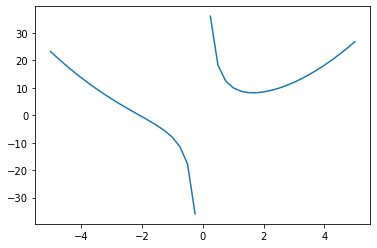

In [125]:
# Non continous function
f = lambda x, coeff=3, power=2: coeff * np.divide(coeff, x) + x ** power
plt.plot(x, f(x))
plt.show()

In [126]:
from scipy.optimize import minimize
import numpy as np

# constrained optimization
min_x, max_x = (0.01, np.inf)

res = minimize(f, 5, args=(3, 2), method='L-BFGS-B', bounds=((min_x, max_x),) ) 
# result dict object
res

      fun: array([8.17704267])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.77635685e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([1.65096367])

<ipython-input-125-34617a66742e>:2: RuntimeWarning: divide by zero encountered in true_divide
  f = lambda x, coeff=3, power=2: coeff * np.divide(coeff, x) + x ** power


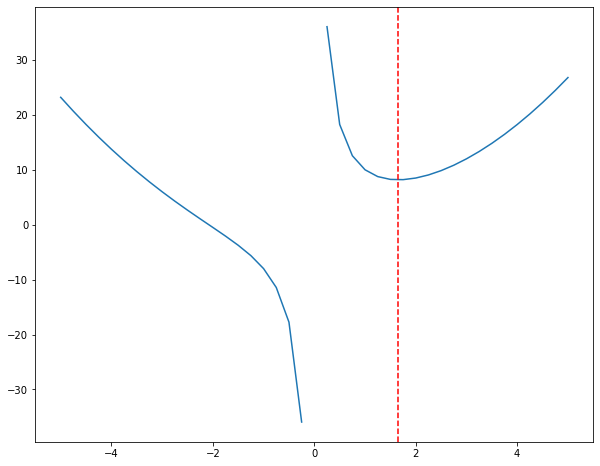

In [127]:
plt.figure(figsize=(10, 8))
plt.plot(x, f(x))
plt.axvline(res['x'], linestyle='--', c='r')
plt.show()

# $$\textbf{Numerical integration with SciPy}$$
<hr> 

In [130]:
f = lambda x, mu, sigma : np.exp(-0.5*(x-mu)**2/sigma**2)

mu = 1; sigma = 2;
args = (mu, sigma)

x = np.arange(-10, 12, 0.1)

def plot_(x, f, args, I=1):
    plt.figure(figsize=(8, 6))
    plt.plot(x, f(x, *args)/I)
    plt.show()

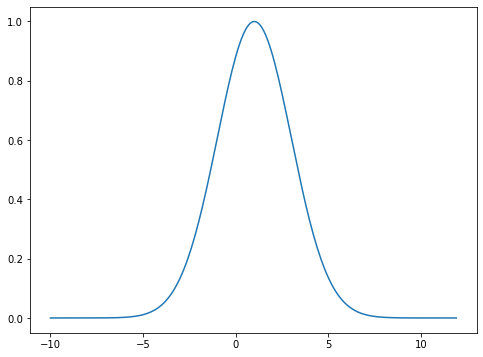

In [131]:
plot_(x, f, args)

$$\Large{
I = \int_a^b f(x)\ dx
}$$

In [101]:
from scipy.integrate import quad as integral

a = -10; b = 12;
I, err = integral(f, a, b, args)

print(f'An estimate of the absolute error in the result: {err}')
I

An estimate of the absolute error in the result: 1.658173531815521e-08


5.013256358862905

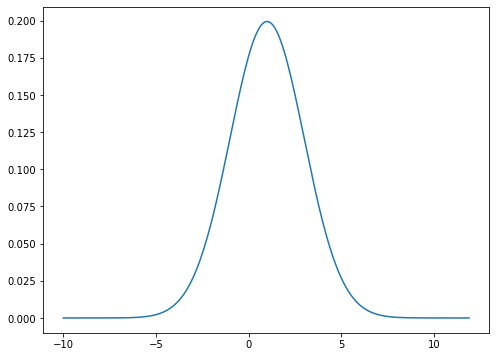

In [63]:
plot_(x, f, args, I)


# $$\textbf{Python code compilation}$$
<hr>

<br><br>
<center>
    <img src='./images/comp.png' width='300'>

## $$\textbf{Making pure Python faster}$$
<hr> 

In [79]:
import math

def is_prime(num):
    
    if num == 2:
        return True
    
    if num <= 1 or num % 2 == 0:
        return False
    
    for div in range(3, int(math.sqrt(num)) + 1, 2): # for 173 -> [3, 5, 7, 9, 11, 13] 
        #print(div)
        if num % div == 0:
            return False
        
    return True
    

In [81]:
is_prime(173)

True

In [82]:
def check_numbers(max_num, verbose=True):
    
    for num in range(0, max_num):
        res = is_prime(num)
        if verbose:
            print(f'{num} -> {res}')
            

In [83]:
check_numbers(25)

0 -> False
1 -> False
2 -> True
3 -> True
4 -> False
5 -> True
6 -> False
7 -> True
8 -> False
9 -> False
10 -> False
11 -> True
12 -> False
13 -> True
14 -> False
15 -> False
16 -> False
17 -> True
18 -> False
19 -> True
20 -> False
21 -> False
22 -> False
23 -> True
24 -> False


## $$\textbf{Benchmark function}$$

In [84]:
from time import time

def benchmark(fn, args=()):
    st = time()
    fn(*args)
    return f'Elapsed time: {(time() - st):0.6f}'

In [85]:
benchmark(check_numbers, args=(1000000, False))

'Elapsed time: 1.789652'

## $$\textbf{A high performance Python compiler}$$
<hr>
<br><br>

<center>
    <img src='./images/numba.png' width='400'>

* $\text{Add an automatic compiler}$

In [86]:
# conda -c conda-forge numba

from numba import njit, prange

@njit(fastmath=True)
def is_prime(num):
    
    if num == 2:
        return True
    
    if num <= 1 or num % 2 == 0:
        return False
    
    for div in range(3, int(math.sqrt(num)) + 1, 2):
        if num % div == 0:
            return False
        
    return True

In [87]:
@njit(fastmath=True)
def check_numbers(max_num):
    for num in range(max_num):
        res = is_prime(num)

In [89]:
benchmark(check_numbers, args=(1000000, ))


'Elapsed time: 0.123240'

## $$\textbf{ Cython}$$
<hr> 

* $\text{Cython is a static compiler for Python programming language}$
<br><br>

<center>
    <img src='./images/cython.png' width='400'>

In [91]:
# conda install -c anaconda cython

import cython

%load_ext cython


The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [92]:
%%cython

#cython: boundscheck=False, wraparound=False, cdivision=True, nonecheck=False

import numpy as np
cimport numpy as np
cimport cython

cdef float[:,:] fill_(int n, float fill_value):
    
    cdef:
        int i
        float[:,:] outs = np.empty((n,n), dtype = np.float32)
    
    for i in range(n):
        for j in range(n):   
            outs[i,j] = fill_value

    return outs


cpdef np.ndarray cdot(float[:,:] X, float[:,:] Y): 
    
    n = len(X)
    cdef:
        int i,j
        float[:,:] Z = fill_(n, 0.)    
    

    for i in range(n):
        for j in range(n):
            for k in range(n):
                Z[i,j] += X[i, k] * Y[k, j]
    
    return np.array(Z)


## $$\textbf{ Measure the performance }$$
<hr> 

In [93]:
n = 500
X = np.random.normal(0,1, size=(n,n)).astype(np.float32)
X.shape, X.dtype

benchmark(cdot, args=(X,X))


'Elapsed time: 0.157497'

In [94]:
%timeit -n 5 -r 3 cdot(X,X)

147 ms ± 4.59 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [96]:
f = lambda X: X @ X 

In [97]:
%timeit -n 5 -r 3 f(X)

1.3 ms ± 421 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


## $$\textbf{ Thank you for your attention }$$